In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.layer_utils import count_params
from time import time
from sklearn.utils import class_weight

In [2]:
marks_names = ['hand_mark_'+str(i).zfill(2)+axis for i in range(21) for axis in ['x','y','z']]
train_labels = marks_names + ['hand_id']

users = pd.read_csv('users.csv')
train_ids = users[users['train']==1]['user_id'].values

f_name= 'results/hand_landmarks.csv'
data = pd.read_csv(f_name)
data['hand_id'] = np.where(data['hand']=='Left', 1, 0)
data.head()

,user,sex,sign,frame,hand,distance,hand_mark_00x,hand_mark_00y,hand_mark_00z,hand_mark_01x,...,hand_mark_18x,hand_mark_18y,hand_mark_18z,hand_mark_19x,hand_mark_19y,hand_mark_19z,hand_mark_20x,hand_mark_20y,hand_mark_20z,hand_id
0,user01,0,5,4,Right,Far,0.576702,1.000000,5.407035e-07,0.410546,...,0.873427,0.506781,-0.076018,0.940664,0.422354,-0.084381,1.000000,0.348559,-0.089569,0
1,user01,0,5,2,Right,Far,0.652267,1.000000,4.608905e-07,0.454004,...,0.917227,0.459302,-0.063588,0.962564,0.362172,-0.070153,1.000000,0.274275,-0.073769,0
2,user01,0,1,24,Right,Near,1.000000,0.835366,-6.396240e-08,0.803085,...,0.225506,1.000000,-0.061369,0.338286,0.988635,-0.050475,0.470683,0.976509,-0.042765,0
3,user01,0,5,3,Right,Far,0.598560,1.000000,5.324617e-07,0.430171,...,0.880562,0.495304,-0.070707,0.944902,0.413304,-0.079948,1.000000,0.341380,-0.085815,0
4,user01,0,1,23,Right,Near,1.000000,0.843810,-1.512659e-07,0.825420,...,0.243031,1.000000,-0.061555,0.368435,0.993640,-0.052067,0.495761,0.972848,-0.044382,0


In [3]:
models = {
    'model_small_without_hand': {
        'labels': marks_names,
        'unknown': False,
        'neurons': [20,10]
    },
    'model_small_with_hand': {
        'labels': marks_names + ['hand_id'],
        'unknown': False,
        'neurons': [20,10]
    },
    'model_big_without_hand': {
        'labels': marks_names,
        'unknown': False,
        'neurons': [30,15]
    },
    'model_big_with_hand': {
        'labels': marks_names + ['hand_id'],
        'unknown': False,
        'neurons': [30,15]
    }
}

In [4]:
def get_data(labels):  

    train_data = data[data['user'].isin(train_ids)]
    test_data = data[~data['user'].isin(train_ids)]

    X_train = train_data[labels].values
    X_test = test_data[labels].values

    y_train = train_data['sign'].values -1
    y_test = test_data['sign'].values -1
    
    return X_train, X_test, y_train, y_test

def get_model(input_size, output_size, neurons=[20,10]):
    model = keras.Sequential(
        [
            keras.Input(shape=(input_size,)),
            #layers.Dropout(0.1),
            layers.Dense(neurons[0], activation="relu"),
            #layers.Dropout(0.1),
            layers.Dense(neurons[1], activation="relu"),
            layers.Dense(output_size, activation='softmax'),
        ]
    )
    return model

model_small_without_hand
INFO:tensorflow:Assets written to: results/models/model_small_without_hand\assets


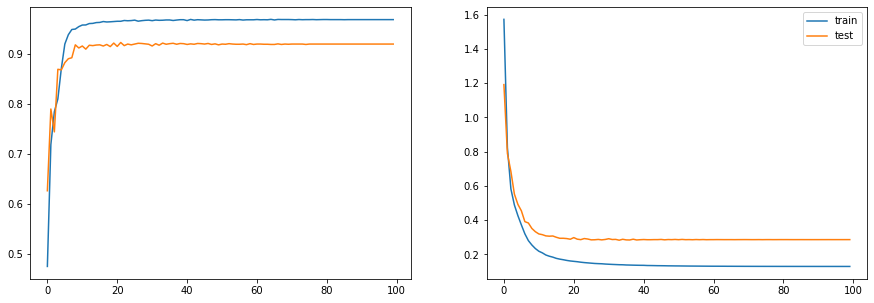

,name,hand,unknown,size,accuracy,val_accuracy,train_parameters,inference_time
0,model_small_without_hand,False,False,small,0.968635,0.919671,1567,0.031286


model_small_with_hand
INFO:tensorflow:Assets written to: results/models/model_small_with_hand\assets


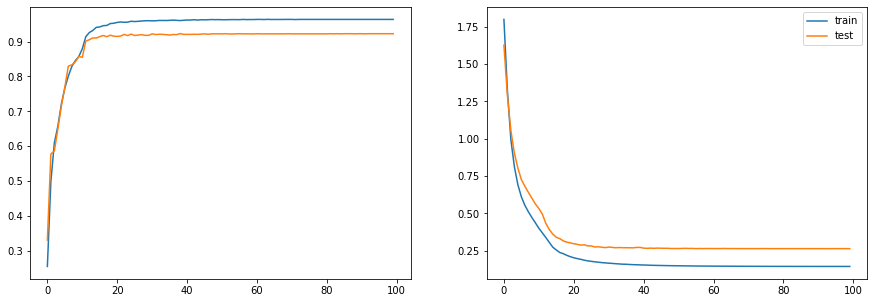

,name,hand,unknown,size,accuracy,val_accuracy,train_parameters,inference_time
0,model_small_without_hand,False,False,small,0.968635,0.919671,1567,0.031286
1,model_small_with_hand,True,False,small,0.963378,0.922414,1587,0.031286


model_big_without_hand
INFO:tensorflow:Assets written to: results/models/model_big_without_hand\assets


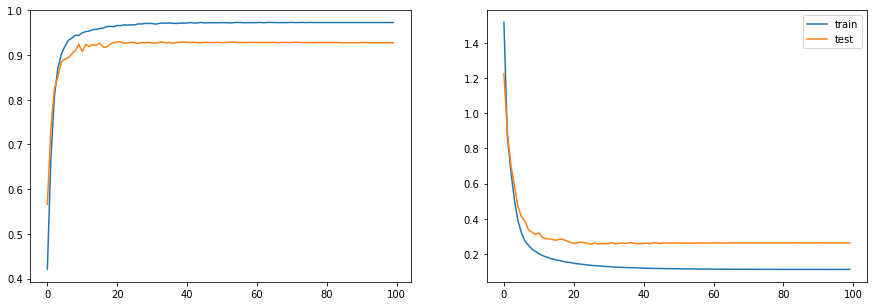

,name,hand,unknown,size,accuracy,val_accuracy,train_parameters,inference_time
0,model_small_without_hand,False,False,small,0.968635,0.919671,1567,0.031286
1,model_small_with_hand,True,False,small,0.963378,0.922414,1587,0.031286
2,model_big_without_hand,False,False,big,0.972665,0.927508,2497,0.031288


model_big_with_hand
INFO:tensorflow:Assets written to: results/models/model_big_with_hand\assets


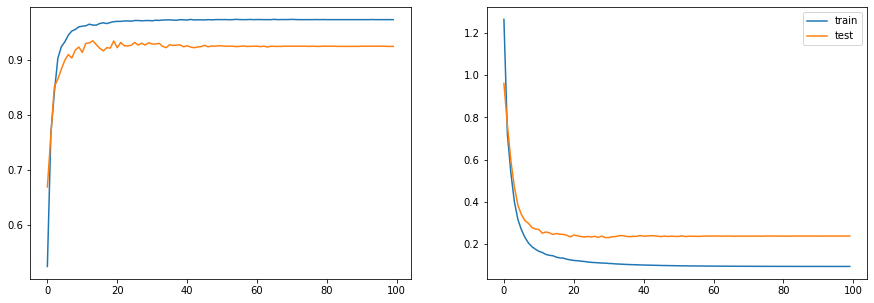

,name,hand,unknown,size,accuracy,val_accuracy,train_parameters,inference_time
0,model_small_without_hand,False,False,small,0.968635,0.919671,1567,0.031286
1,model_small_with_hand,True,False,small,0.963378,0.922414,1587,0.031286
2,model_big_without_hand,False,False,big,0.972665,0.927508,2497,0.031288
3,model_big_with_hand,True,False,big,0.973366,0.924765,2527,0.031283


In [5]:
model_data = pd.DataFrame(columns=['name', 'hand', 'unknown','size','accuracy', 'val_accuracy', 'train_parameters', 'inference_time'])

for m in models:
    print(m)
    X_train, X_test, y_train, y_test = get_data(models[m]['labels'])
    class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
    class_weights = dict(zip(np.unique(y_train), class_weights))
    output = 8 if models[m]['unknown'] else 7
    model = get_model(len(models[m]['labels']), output, models[m]['neurons'])
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-3,decay_steps=25,decay_rate=0.96)
    adam = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    h = model.fit(X_train,y_train,epochs=100,batch_size=128,validation_data=(X_test, y_test), verbose=False,class_weight=class_weights)
    
    times = []
    tensor = X_train[0:1,:]
    for i in range(50):
        start = time()
        model.predict(tensor, verbose=False)
        evaluation_time = (time()-start)
        times.append(evaluation_time)
    inference_time = np.median(np.array(times[25:]))
    m_info =m.split('_')
    hand_info = True if m_info[2]=='with' else False
    unknown_info = False
    
    df_historic = pd.DataFrame(h.history)
    df_historic.to_csv('results/models/'+m+'.csv')
    model.save('results/models/'+m)

    fig, ax = plt.subplots(1,2, figsize=(15, 5))

    ax[0].plot(df_historic['accuracy'].values, label='acc')
    ax[0].plot(df_historic['val_accuracy'].values, label='val_acc')
    ax[1].plot(df_historic['loss'].values, label='train')
    ax[1].plot(df_historic['val_loss'].values, label='test')
    plt.legend()

    plt.show()
    
    df = pd.DataFrame([{'name':m,'accuracy':df_historic['accuracy'].values[-1], 
                        'hand': hand_info, 'unknown': unknown_info, 'size': m_info[1],
                        'val_accuracy':df_historic['val_accuracy'].values[-1],
                        'train_parameters':count_params(model.trainable_weights),
                        'inference_time':inference_time}])
    model_data = pd.concat([model_data, df], ignore_index=True)
    display(model_data.head())
model_data.to_csv('results/classifier_results.csv')

In [6]:
model_data = pd.read_csv('results/classifier_results.csv')
model_data['inference_time'] = model_data['inference_time']*1000 #(ms)
model_data['inference_time'] = model_data['inference_time'].round(decimals=2)
model_data['accuracy'] = model_data['accuracy'].round(decimals =4)
model_data['val_accuracy'] = model_data['val_accuracy'].round(decimals =4)
#model_data.sort_values(by='val_accuracy')

In [7]:
model_data.head()

,Unnamed: 0,name,hand,unknown,size,accuracy,val_accuracy,train_parameters,inference_time
0,0,model_small_without_hand,False,False,small,0.9686,0.9197,1567,31.29
1,1,model_small_with_hand,True,False,small,0.9634,0.9224,1587,31.29
2,2,model_big_without_hand,False,False,big,0.9727,0.9275,2497,31.29
3,3,model_big_with_hand,True,False,big,0.9734,0.9248,2527,31.28
